In [1]:
import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import theano.tensor as tt

import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

#### Model: https://towardsdatascience.com/how-bayesian-statistics-convinced-me-to-hit-the-gym-fa737b0a7ac

In [2]:
df = pd.read_csv('file1.csv', index_col=False, sep=";")
df = df[(df.Age_gr == '18-29')&(df.Sex=='male')]

df.weight = df.weight.apply(lambda x: float(x.replace(',','.')))
df.height = df.height.apply(lambda x: float(x.replace(',','.')))

print(df.shape)
df.T.head(n=10)

(383, 50)

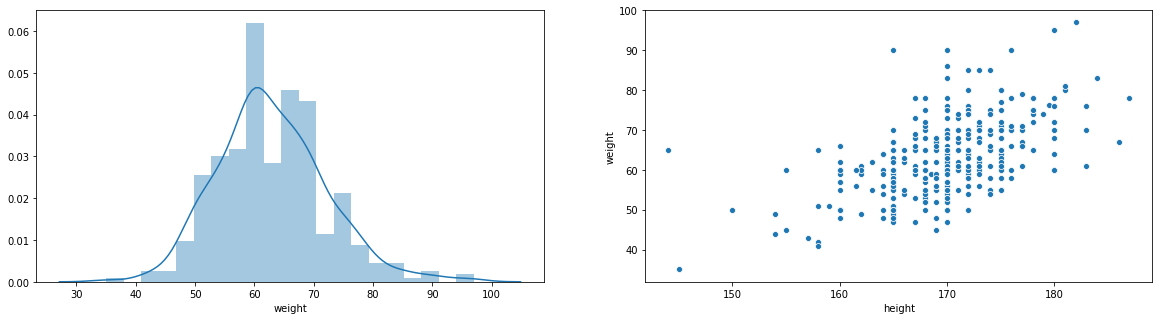

In [4]:
fig, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)
sns.distplot(df.weight, ax=ax[0])
sns.scatterplot(data=df, x='height', y='weight', ax=ax[1])

#### MCMC

In [5]:
X = np.array(df['height'].tolist()).reshape(1, -1)
y = np.array(df['weight'].tolist()).reshape(1, -1)

def linear_regression(X,y):
    with pm.Model() as model:
        intercept = pm.Flat('intercept')
        beta = pm.Flat('beta')
        sigma = pm.HalfCauchy('sigma', beta=10.)
        y_obs = pm.Normal('y', mu=intercept + beta*X, sd=sigma, observed=y.squeeze())
    return model
linear_regression = linear_regression(X,y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:40<00:00, 124.70draws/s]
The acceptance probability does not match the target. It is 0.8994706618396981, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802333648686976, but should be close to 0.8. Try to increase the number of tuning steps.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,327.2, ||grad|| = 5.7237: 100%

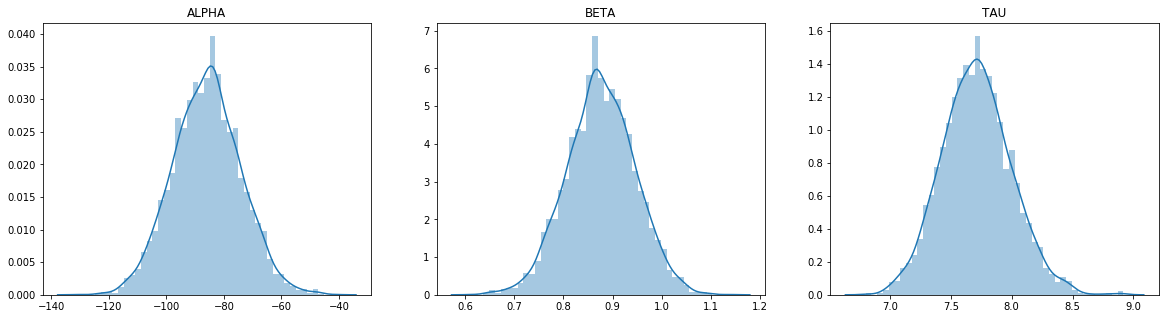

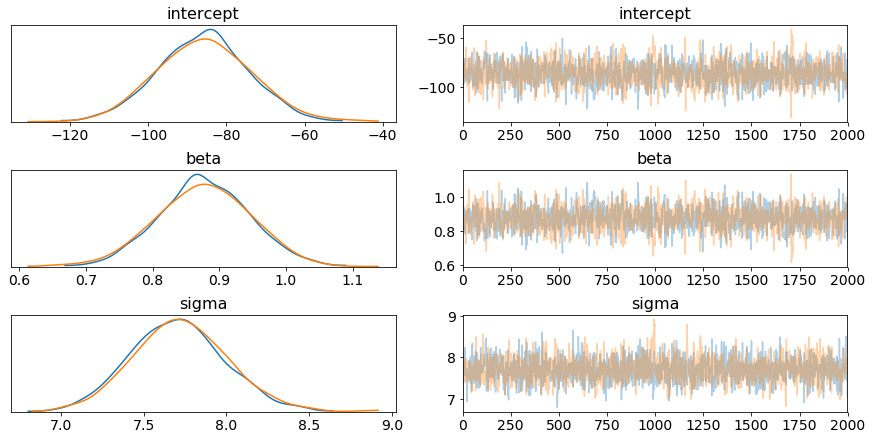

In [8]:
with linear_regression as model:
    
    trace = pm.sample(2000)
    
    map_estimate = pm.find_MAP(model=model)
    intercept_mcmc = map_estimate['intercept']
    beta_mcmc = map_estimate['beta']
    
    # Plots
    fig, ax = plt.subplots(figsize=(20,5), ncols=3, nrows=1)
    sns.distplot(trace['intercept'], ax=ax[0]); ax[0].set_title('Intercept')
    sns.distplot(trace['beta'], ax=ax[1]); ax[1].set_title('Beta')
    sns.distplot(trace['sigma'], ax=ax[2]); ax[2].set_title('Sigma')
    plt.show()
    
    pm.traceplot(trace)

#### Replicate Linear Regression

Text(0.5, 1.0, 'MCMC Posterior probability: slope: 0.8785495349854835 & intecept: -86.32192197926027')

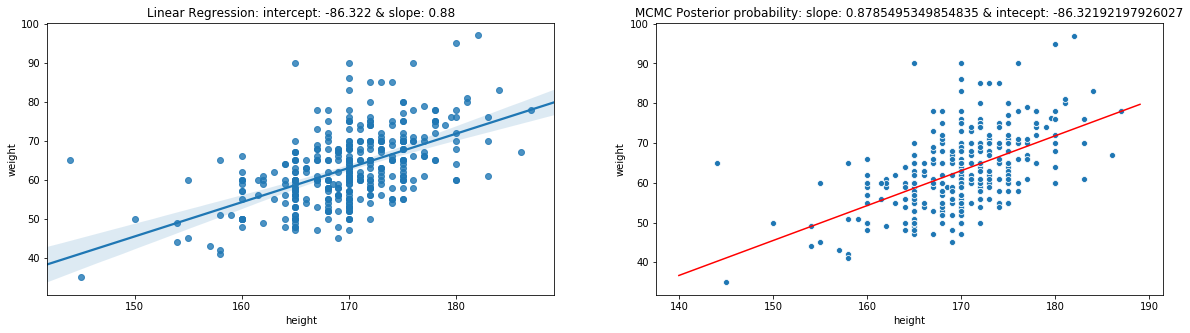

In [10]:
fig, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)

######################
sns.regplot(data=df, x='height', y='weight', ax=ax[0])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, y)
X_plot = [i for i in range(140, 190)]
Y_plot = [intercept + slope*i for i in X_plot]
title = 'Linear Regression: ' + 'intercept: ' + str(round(intercept, 4)) + ' & slope: ' + str(round(slope, 2))
ax[0].set_title(title)

######################
sns.scatterplot(data=df, x='height', y='weight', ax=ax[1])

X_plot = [i for i in range(140, 190)]
Y_plot = [intercept_mcmc + beta_mcmc * i for i in X_plot]
ax[1].plot(X_plot, Y_plot, color='r')

title = 'MCMC Posterior probability: ' + 'slope: ' + str(beta_mcmc.item())
title +=' & intecept: ' + str(intercept_mcmc.item())
ax[1].set_title(title)

#### Show posterior probabilities

Text(0.5, 1.0, 'Max prob: 0.3356991520233119')

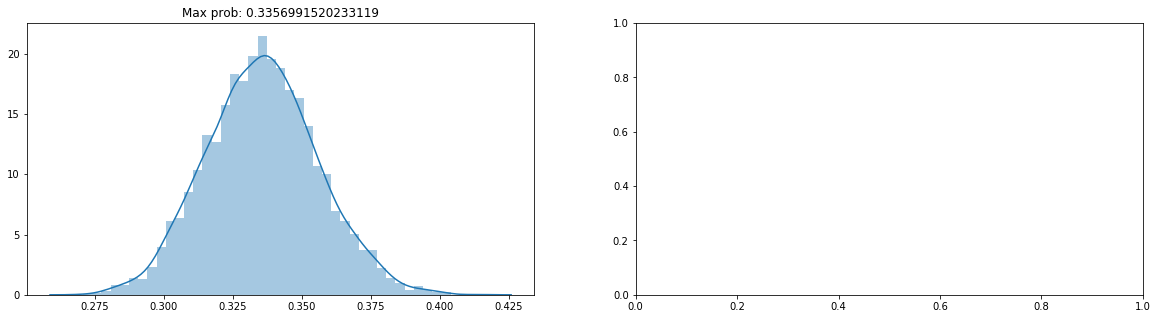

In [30]:
mu = trace['intercept'] + 168. * trace['beta']

percentiles = scipy.stats.norm.cdf(58, mu, trace['sigma'])

median = np.median(percentiles)

fig, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)
sns.distplot(percentiles, ax=ax[0])
ax[0].set_title('Max prob: ' + str(median))